# Approximate q-learning

In this notebook you will teach a lasagne neural network to do Q-learning.

__Frameworks__ - we'll accept this homework in any deep learning framework. For example, it translates to TensorFlow almost line-to-line. However, we recommend you to stick to theano/lasagne unless you're certain about your skills in the framework of your choice.

In [1]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [5]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

[2017-09-22 22:34:21,100] Making new env: CartPole-v0


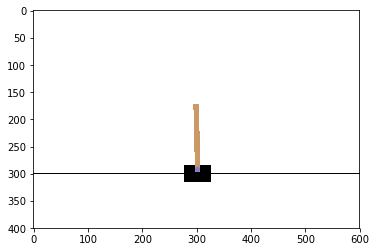

In [6]:
env = gym.make("CartPole-v0")
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Approximate (deep) Q-learning: building the network

In this section we will build and train naive Q-learning with theano/lasagne

First step is initializing input variables

In [7]:
import theano
import theano.tensor as T

#create input variables. We'll support multiple states at once


current_states = T.matrix("states[batch,units]")
actions = T.ivector("action_ids[batch]")
rewards = T.vector("rewards[batch]")
next_states = T.matrix("next states[batch,units]")
is_end = T.ivector("vector[batch] where 1 means that session just ended")

In [8]:
import lasagne
from lasagne.layers import *

In [9]:
#input layer
l_states = InputLayer((None,)+state_dim)

#<Your architecture. Please start with a single-layer network>
dense_1 = DenseLayer(l_states, num_units=30, nonlinearity=lasagne.nonlinearities.rectify, name='dense_1')
dense_2 = DenseLayer(dense_1, num_units=40, nonlinearity=lasagne.nonlinearities.rectify, name='dense_2')
dense_3 = DenseLayer(dense_2, num_units=30, nonlinearity=lasagne.nonlinearities.rectify, name='dense_3')

#output layer
l_qvalues = DenseLayer(dense_3, num_units=n_actions, nonlinearity=None)

#### Predicting Q-values for `current_states`

In [63]:
#get q-values for ALL actions in current_states
predicted_qvalues = get_output(l_qvalues, {l_states:current_states})

In [64]:
#compiling agent's "GetQValues" function
#get_qvalues = <compile a function that takes current_states and returns predicted_qvalues>
get_qvalues = theano.function(inputs=[current_states],
                              outputs=[predicted_qvalues])

In [65]:
#select q-values for chosen actions
predicted_qvalues_for_actions = predicted_qvalues[T.arange(actions.shape[0]), actions]

#### Loss function and `update`
Here we write a function similar to `agent.update`.

In [66]:
#predict q-values for next states
predicted_next_qvalues = get_output(l_qvalues, {l_states:next_states})


#Computing target q-values under 
gamma = 0.99
#target_qvalues_for_actions = <target Q-values using rewards and predicted_next_qvalues>
target_qvalues_for_actions = rewards + gamma*T.max(predicted_next_qvalues, axis=1)

#zero-out q-values at the end
target_qvalues_for_actions = (1-is_end)*target_qvalues_for_actions

#don't compute gradient over target q-values (consider constant)
target_qvalues_for_actions = theano.gradient.disconnected_grad(target_qvalues_for_actions)

In [67]:

#mean squared error loss function
#loss = <mean squared between target_qvalues_for_actions and predicted_qvalues_for_actions>
loss = T.mean(lasagne.objectives.squared_error(predicted_qvalues_for_actions, target_qvalues_for_actions))


In [68]:
#all network weights
all_weights = get_all_params(l_qvalues, trainable=True)

#network updates. Note the small learning rate (for stability)
updates = lasagne.updates.sgd(loss,all_weights,learning_rate=1e-4)

In [69]:
#Training function that resembles agent.update(state,action,reward,next_state) 
#with 1 more argument meaning is_end
train_step = theano.function([current_states,actions,rewards,next_states,is_end],
                             updates=updates)

### Playing the game

In [70]:
epsilon = 0.25 #initial epsilon

def generate_session(t_max=1000):
    """play env with approximate q-learning agent and train it at the same time"""
    
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        
        #get action q-values from the network
        q_values = get_qvalues([s])[0] 
        
        #a = <sample action with epsilon-greedy strategy>
        val = np.random.random()
        if val < epsilon:
            a = np.random.randint(n_actions)
        else:
            a = np.argmax(q_values)
        
        new_s,r,done,info = env.step(a)
        
        #train agent one step. Note that we use one-element arrays instead of scalars 
        #because that's what function accepts.
        train_step([s],[a],[r],[new_s],[done])
        
        total_reward += r
        
        s = new_s
        if done: break
            
    return total_reward
        

In [72]:
for i in range(100):
    
    rewards = [generate_session() for _ in range(100)] #generate new sessions
    
    epsilon*=0.95
    
    print ("mean reward:%.3f\tepsilon:%.5f"%(np.mean(rewards),epsilon))

    if np.mean(rewards) > 300:
        print ("You Win!")
        break
        
    assert epsilon != 0, "Please explore environment"

mean reward:183.300	epsilon:0.00141
mean reward:186.860	epsilon:0.00134
mean reward:165.020	epsilon:0.00127
mean reward:200.000	epsilon:0.00121
mean reward:180.380	epsilon:0.00115
mean reward:196.330	epsilon:0.00109
mean reward:196.270	epsilon:0.00103
mean reward:184.610	epsilon:0.00098
mean reward:159.290	epsilon:0.00093
mean reward:168.370	epsilon:0.00089
mean reward:193.700	epsilon:0.00084
mean reward:95.060	epsilon:0.00080
mean reward:11.440	epsilon:0.00076
mean reward:12.070	epsilon:0.00072
mean reward:13.730	epsilon:0.00069
mean reward:12.090	epsilon:0.00065
mean reward:11.720	epsilon:0.00062
mean reward:11.440	epsilon:0.00059
mean reward:11.270	epsilon:0.00056
mean reward:11.390	epsilon:0.00053
mean reward:11.920	epsilon:0.00050
mean reward:12.540	epsilon:0.00048
mean reward:11.890	epsilon:0.00045
mean reward:15.110	epsilon:0.00043
mean reward:13.790	epsilon:0.00041
mean reward:13.680	epsilon:0.00039
mean reward:15.520	epsilon:0.00037
mean reward:20.760	epsilon:0.00035
mean rewa

### Video

In [73]:
epsilon = 0 #Don't forget to reset epsilon back to initial value if you want to go on training

In [74]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(env,directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()
#unwrap 
env = env.env.env
#upload to gym
#gym.upload("./videos/",api_key="<your_api_key>") #you'll need me later

#Warning! If you keep seeing error that reads something like"DoubleWrapError",
#run env=gym.make("CartPole-v0");env.reset();

[2017-09-21 22:26:29,995] Clearing 6 monitor files from previous run (because force=True was provided)
[2017-09-21 22:26:29,999] Starting new video recorder writing to C:\Users\1\Documents\RL_practice\Practical_RL\week3.5\videos\openaigym.video.2.7964.video000000.mp4
[2017-09-21 22:26:33,646] Starting new video recorder writing to C:\Users\1\Documents\RL_practice\Practical_RL\week3.5\videos\openaigym.video.2.7964.video000001.mp4
[2017-09-21 22:26:37,381] Starting new video recorder writing to C:\Users\1\Documents\RL_practice\Practical_RL\week3.5\videos\openaigym.video.2.7964.video000008.mp4
[2017-09-21 22:26:41,817] Starting new video recorder writing to C:\Users\1\Documents\RL_practice\Practical_RL\week3.5\videos\openaigym.video.2.7964.video000027.mp4
[2017-09-21 22:26:47,063] Starting new video recorder writing to C:\Users\1\Documents\RL_practice\Practical_RL\week3.5\videos\openaigym.video.2.7964.video000064.mp4
[2017-09-21 22:26:52,332] Finished writing results. You can upload them 

In [75]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

### Homework

Two paths lie ahead of you, and which one to take is a rightfull choice of yours.

* __[recommended]__ Go deeper. Return to seminar1 and get 99% accuracy on MNIST
* __[alternative]__ Try approximate expected-value SARSA and other algorithms and compare it with q-learning 
  * +3 points for EV-SARSA and comparison to Q-learning
  * +2 per additional algorithm
* __[alternative hard]__ Pick ```<your favourite env>``` and solve it, using NN.
 * LunarLander, MountainCar or Breakout (from week1 bonus)
 * LunarLander should get at least +100
 * MountainCar should get at least -200
 * You will need to somehow stabilize learning
   
